# LUCAS Dataset imbalanced class prediction problem

## Imports

In [1]:
import pandas as pd
import sqlite3
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler

# oversamplers
from sklearnext.over_sampling import SMOTE, GeometricSMOTE, RandomOverSampler

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# utils
from sklearnext.model_selection import ModelSearchCV
from sklearnext.tools import report_model_search_results
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Hyperparams

In [2]:
%config InlineBackend.figure_format = 'retina'

correlation_threshold = 0.9

## Reading pre-treated data

In [3]:
data_version = 'wide'

if data_version == 'long':
    conn = sqlite3.connect('../data/interim/remote_sensing_data.db')
    df = pd.read_sql_query('SELECT * FROM lucas', conn)
elif data_version == 'wide':
    df = pd.read_csv('../data/interim/data.csv')
    df = df[list(df.columns)[1:]+['class']]


## General data exploration

In [4]:
df.groupby('class').size()

class
A    131
B    270
C    761
D    296
E    185
F     37
G     10
H      4
dtype: int64

![class labels](https://ec.europa.eu/eurostat/statistics-explained/images/9/99/LUCAS_-_classification_of_land_cover.png)

In [5]:
# Degree of Dimensionality
DoD = lambda sample_size, features: sample_size/features
ft = len(df.columns)-1 # -1 is used to disregard the column "class"
df.groupby('class').size().apply(lambda sample_size: DoD(sample_size, ft))

class
A     2.729167
B     5.625000
C    15.854167
D     6.166667
E     3.854167
F     0.770833
G     0.208333
H     0.083333
dtype: float64

In [6]:
# Imbalance Ratio
IR = lambda majority_class, class_label: majority_class/class_label
majority_class = df.groupby('class').size().max()
df.groupby('class').size().apply(lambda class_size: IR(majority_class, class_size))

class
A      5.809160
B      2.818519
C      1.000000
D      2.570946
E      4.113514
F     20.567568
G     76.100000
H    190.250000
dtype: float64

In [7]:
report = pandas_profiling.ProfileReport(df, correlation_threshold=correlation_threshold)
report

Number of variables,49
Number of observations,1694
Total Missing (%),0.0%
Total size in memory,648.6 KiB
Average record size in memory,392.0 B
Numeric,16
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,32


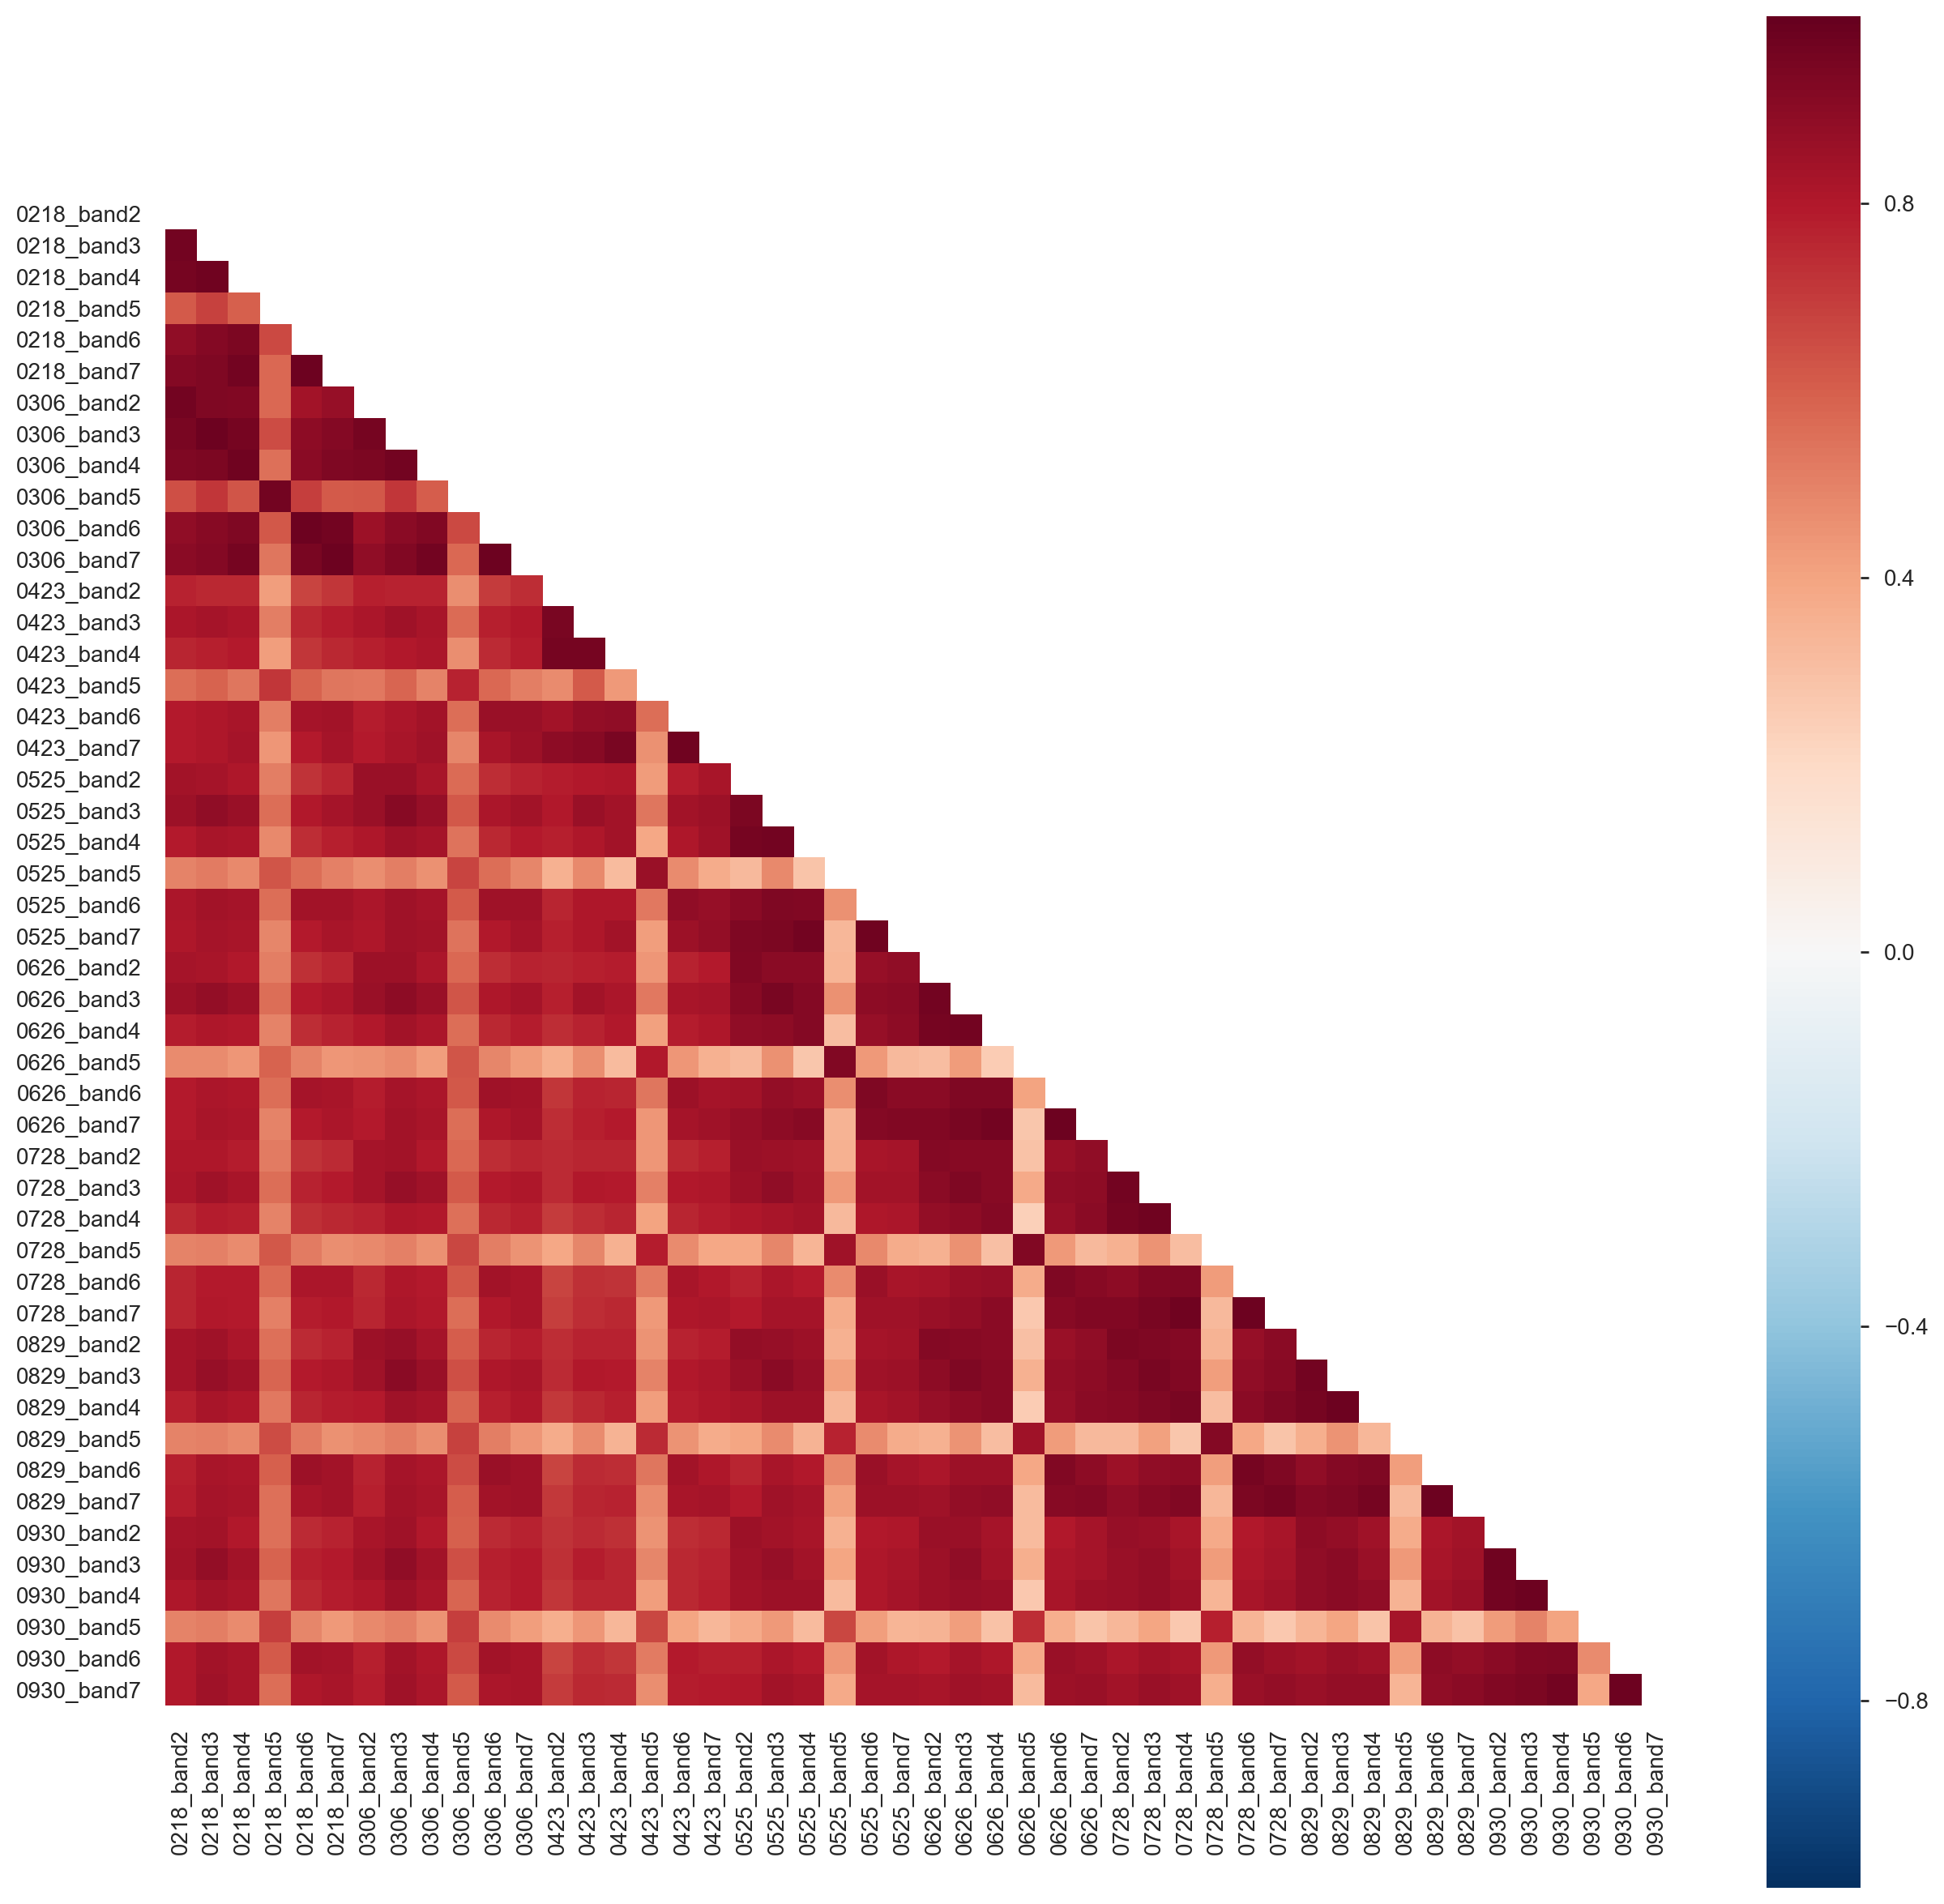

In [8]:
def make_corr_table(df, method='spearman', fig_size=(15,15)):
    corr = df.corr(method=method)
    # remove the upper diagonal of the correlation matrix
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        fig, ax = plt.subplots()
        fig.set_size_inches(fig_size[0], fig_size[1])
        sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, ax=ax, cmap='RdBu_r')
    
    
make_corr_table(df)

## Preprocessing stage

In [9]:
# See notebook 2.0 if further preprocessing is necessary
sc = StandardScaler()
_X = df.values[:,:-1]
X = sc.fit_transform(_X)
y = df.values[:,-1]






## Modelling

In [10]:
def model_search(X, y, approach='standard'):
    """
    Function built for convenience purposes. oversamplers, classifiers etc etc must be edited in the function itself,
    if necessary.
    """
    global oversamplers, classifiers, grid, param_grids, estimators
    
    configs = {
        'scoring': ['f1_weighted', 'accuracy'],
        'n_splits': 5,
        'n_runs': 3,
        'random_state': 0,
        'n_jobs': -1,
        'verbose':1
    }
    
    
    oversamplers = [
        ('none', None),
        #('RandomOverSampler', RandomOverSampler()),
        #('smote', SMOTE()),
        ('gsmote', GeometricSMOTE())
    ]

    classifiers = [
        #('GBC', GradientBoostingClassifier()),
        ('DT', DecisionTreeClassifier()),
        ('KNN', KNeighborsClassifier()),
        #('LR', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1e4)),
    ]


    grid = {
        #'smote': {'k_neighbors': [2, 3, 4, 5]},
        'gsmote': {
            'k_neighbors': [2, 3, 4, 5],
            #'truncation_factor': [-1.0, -0.5, .0, 0.25, 0.5, 0.75, 1.0], 
            #'deformation_factor': [.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0],
            #'selection_strategy': ['combined', 'minority', 'majority']
        },
        'DT':{'max_depth': [3, 6]},
        'KNN':{'n_neighbors':[3,4,5,6,7]},
        #'GBC':{
        #    'max_depth': [3, 6], 
        #    'n_estimators': [50, 100]
        #}
    }

    param_grids = []
    estimators = []
    
    for oversampler in oversamplers:
        for classifier in classifiers:

            # sets up pipeline with name
            name = f'{oversampler[0]}+{classifier[0]}'
            if approach == 'standard':
                estimators.append((name, Pipeline([oversampler, classifier])))
            elif approach == 'onevsrest':
                estimators.append((name, OneVsRestClassifier(Pipeline([oversampler, classifier]))))
            elif approach == 'onevsone':
                estimators.append((name, OneVsOneClassifier(Pipeline([oversampler, classifier]))))
                

            # sets up param grid for the estimator
            param_grid = {}
            if oversampler[0] in grid.keys(): 
                for key, value in grid[oversampler[0]].items():
                    if approach == 'standard':
                        param_grid[f'{name}__{oversampler[0]}__{key}'] = value
                    elif approach in ['onevsrest', 'onevsone']:
                        param_grid[f'{name}__estimator__{oversampler[0]}__{key}'] = value

            if classifier[0]  in grid.keys(): 
                for key, value in grid[classifier[0]].items():
                    if approach == 'standard':
                        param_grid[f'{name}__{classifier[0]}__{key}'] = value
                    elif approach in ['onevsrest', 'onevsone']:
                        param_grid[f'{name}__estimator__{classifier[0]}__{key}'] = value
            if len(param_grid)>0:
                param_grids.append(param_grid)


    model_search_cv = ModelSearchCV(
        estimators=estimators, 
        param_grids=param_grids, 
        scoring=configs['scoring'], 
        cv=StratifiedKFold(n_splits=configs['n_splits'], shuffle=True),
        refit=False, 
        n_jobs=configs['n_jobs'],
        verbose=configs['verbose']
    )

    model_search_cv.fit(X, y)

    return model_search_cv

In [13]:
param_grids



[{'none+DT__DT__max_depth': [3, 6]},
 {'none+KNN__KNN__n_neighbors': [3, 4, 5, 6, 7]},
 {'gsmote+DT__gsmote__k_neighbors': [2, 3, 4, 5],
  'gsmote+DT__DT__max_depth': [3, 6]},
 {'gsmote+KNN__gsmote__k_neighbors': [2, 3, 4, 5],
  'gsmote+KNN__KNN__n_neighbors': [3, 4, 5, 6, 7]}]

## Experiments

In [11]:

approaches = ['standard', 'onevsrest', 'onevsone']
results = {}
for approach in approaches:
    model_search_cv = model_search(X, y, approach=approach)
    results[approach] = report_model_search_results(model_search_cv)

cols = list(list(results.values())[0].columns)
cols.append('method')
df_results = pd.DataFrame(columns=cols)

for key, df_pre_results in results.items():
    df_pre_results['method'] = key
    df_results = pd.concat([df_results, df_pre_results])

df_results['oversampler'] = df_results['models'].apply(lambda x: x.split('+')[0])
df_results['classifier'] = df_results['models'].apply(lambda x: x.split('+')[1])
df_results.shape

Fitting 5 folds for each of 35 candidates, totalling 175 fits


/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s


KeyboardInterrupt: 